In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import wfdb
from neurokit import ecg_preprocess,ecg_process
from pyts.transformation import ShapeletTransform

In [2]:
def get_SCD_time(scd_path):
    '''
    Get the happen time of SCA in every record
    Unit : second
    Return dict{ record_name : time}
    '''
    scd_time = {}
    for filename_ext in os.listdir(scd_path):
        (filename,ext) = os.path.splitext(filename_ext)
        if ext == '.hea':
            file = open(scd_path+filename+'.hea')
            info = [int(i) for i in file.read().split()[-1].split(':')]
            time = (info[0]*60+info[1])*60+info[2]
            scd_time[filename] = time
    return scd_time

In [3]:
nsr_path = '../Dataset/mit-bih-normal-sinus-rhythm-database-1.0.0/'
scd_path = '../Dataset/sudden-cardiac-death-holter-database-1.0.0/'
ecg_info_save_path = '../Dataset/ecg_info/'
hrv_info_save_path = '../Dataset/hrv_info/'
scd_fs = 250
nsr_fs = 128
# preprocess index define: delete 3 records since there SCA don't happen among them and 2 records because of their bad signal quality
scd_indexs = ['30','31','32','33','34','35','36','38','41','43','44','45','46','47','48','50','51','52']
nsr_indexs = ['16265','16272','16273','16420','16483','16539','16773','16786','16795','17052','17453','18177','18184','19088','19090','19093','19140','19830']
polarity = [1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,1,1,1,1,1,1,1]
scd_time = get_SCD_time(scd_path)
# ======================================================================================================
# ECG preprocess API
# 得到预处理后的ECG基本信息
# 返回结果为字典
# 去噪信号为 ['df']['ECG_Filtered']
# 心脏收缩/舒张标记 ['df']['ECG_Systole']
# R波波峰为 ['ECG']['R_Peaks']
# 分割后的心拍为 ['ECG'][Cardiac_Cycles]
# 各类特征波点为 ['ECG']['P_Waves'] // ['ECG']['Q_Waves'] //  ['ECG']['S_Waves'] // ['ECG']['T_Waves']
# 细微波形起止点 ['ECG']['Q_Waves_Onsets'] // ['ECG']['T_Waves_Onsets'] // ['ECG']['T_Waves_Ends']
# =======================================================================================================
# 注意不要输入过长的ECG信号，长度为1000000以内为宜
# =======================================================================================================

In [4]:
def get_SCD_ecg_info(scd_path,scd_indexs,ecg_info_save_path,length=600,channels=[0,1],resample_fs=128,polarity=1):
    '''
    Extract the SCD-ECG infomation
    param:      scd_path            -> The path to save the SCD record
                scd_indexs          -> The record indexs to extract ECG infomation
                ecg_info_save_path  -> The path to save the ECG infomation
                length              -> The time length to extract ECG infomation,unit(second)
                channels            -> The channels to extract ECG infomation for mutil-channels record 
                resample_fs         -> The frequency of resample
                polarity            -> The polarity of channels
    '''
    scd_time = get_SCD_time(scd_path)
    for index in scd_indexs:
        if scd_time[index]<length:
            print("the time of record {0} is shorter than {1} seconds!".format(index,length))
            continue
        record = wfdb.rdrecord(scd_path+index,physical=False,channels=channels)
        fs = record.fs
        date_index = pd.date_range('2021-1-1 0:0:0',periods=length*fs,freq=str(1000000/fs)+'U')
        for i in channels:
            signal = record.d_signal[(scd_time[index]-length)*fs:scd_time[index]*fs,i]*polarity
            ecg_info = ecg_preprocess(signal,fs)
            ecg_signal = ecg_info['df']
            ecg_signal['index'] = date_index
            ecg_signal = ecg_signal.set_index('index').resample(str(1000000/resample_fs)+'U').mean() # 重采样
            rpeaks = pd.Series(np.asarray(ecg_info['ECG']['R_Peaks']*resample_fs/fs,dtype=np.int32))
            twaves = {}
            twaves['t_peaks'] = np.asarray(np.asarray(ecg_info['ECG']['T_Waves'])*resample_fs/fs,dtype=np.int32)
            twaves['t_onsets'] = np.asarray(np.asarray(ecg_info['ECG']['T_Waves_Onsets'])*resample_fs/fs,dtype=np.int32)
            twaves['t_ends'] = np.asarray(np.asarray(ecg_info['ECG']['T_Waves_Ends'])*resample_fs/fs,dtype=np.int32)
            twaves = pd.DataFrame(twaves,columns=['t_peaks','t_onsets','t_ends'])
            qwaves = {}
            qwaves['q_peaks'] = np.asarray(np.asarray(ecg_info['ECG']['Q_Waves'])*resample_fs/fs,dtype=np.int32)
            qwaves['q_onsets'] =np.asarray(np.asarray(ecg_info['ECG']['Q_Waves_Onsets'])*resample_fs/fs,dtype=np.int32)
            qwaves = pd.DataFrame(qwaves,columns=['q_peaks','q_onsets'])
            heart_beat = ecg_info['ECG']['Cardiac_Cycles'].resample(str(1000000/resample_fs)+'U',closed='left').mean() # 重采样
            for col in range(heart_beat.shape[1]):
                heart_beat[col] = (heart_beat[col]-np.min(heart_beat[col]))/(np.max(heart_beat[col])-np.min(heart_beat[col])) # 归一化
            ecg_signal.to_csv(ecg_info_save_path+index+'_ecg_chan{}.csv'.format(i),index=False)
            rpeaks.to_csv(ecg_info_save_path+index+'_rpeaks_chan{}.csv'.format(i),index=False)
            twaves.to_csv(ecg_info_save_path+index+'_twaves_chan{}.csv'.format(i),index=False)
            qwaves.to_csv(ecg_info_save_path+index+'_qwaves_chan{}.csv'.format(i),index=False)
            heart_beat.to_csv(ecg_info_save_path+index+'_heartbeat_chan{}.csv'.format(i),index_label='index')
            print("the record {} channel {} finished!!".format(index,i))

In [5]:
def get_NSR_ecg_info(nsr_path,nsr_indexs,ecg_info_save_path,length=600,channels=[0,1],resample_fs=128):
    '''
    Extract the NSR-ECG infomation
    param:      nsr_path            -> The path to save the NSR record
                nsr_indexs          -> The record indexs to extract ECG infomation
                ecg_info_save_path  -> The path to save the ECG infomation
                length              -> The time length to extract ECG infomation,unit(second)
                channels            -> The channels to extract ECG infomation for mutil-channels record 
    '''
    for index in nsr_indexs:
        record = wfdb.rdrecord(nsr_path+index,physical=False,channels=channels)
        fs = record.fs
        date_index = pd.date_range('2021-1-1 0:0:0',periods=length*fs,freq=str(1000000/fs)+'U')
        start = np.random.randint(0,len(record.d_signal)-fs*length)
        for i in channels:
            signal = record.d_signal[start:start+length*fs,i]
            ecg_info = ecg_preprocess(signal,fs)
            ecg_signal = ecg_info['df']
            ecg_signal['index'] = date_index
            ecg_signal = ecg_signal.set_index('index').resample(str(1000000/resample_fs)+'U').mean() # 重采样
            rpeaks = pd.Series(np.asarray(ecg_info['ECG']['R_Peaks']*resample_fs/fs,dtype=np.int32))
            twaves = {}
            twaves['t_peaks'] = np.asarray(np.asarray(ecg_info['ECG']['T_Waves'])*resample_fs/fs,dtype=np.int32)
            twaves['t_onsets'] = np.asarray(np.asarray(ecg_info['ECG']['T_Waves_Onsets'])*resample_fs/fs,dtype=np.int32)
            twaves['t_ends'] = np.asarray(np.asarray(ecg_info['ECG']['T_Waves_Ends'])*resample_fs/fs,dtype=np.int32)
            twaves = pd.DataFrame(twaves,columns=['t_peaks','t_onsets','t_ends'])
            qwaves = {}
            qwaves['q_peaks'] = np.asarray(np.asarray(ecg_info['ECG']['Q_Waves'])*resample_fs/fs,dtype=np.int32)
            qwaves['q_onsets'] =np.asarray(np.asarray(ecg_info['ECG']['Q_Waves_Onsets'])*resample_fs/fs,dtype=np.int32)
            qwaves = pd.DataFrame(qwaves,columns=['q_peaks','q_onsets'])
            heart_beat = ecg_info['ECG']['Cardiac_Cycles'].resample(str(1000000/resample_fs)+'U').mean() # 重采样
            for col in range(heart_beat.shape[1]):
                heart_beat[col] = (heart_beat[col]-np.min(heart_beat[col]))/(np.max(heart_beat[col])-np.min(heart_beat[col]))
            # 每个心拍需要各自做归一化
            ecg_signal.to_csv(ecg_info_save_path+index+'_ecg_chan{}.csv'.format(i),index=False)
            rpeaks.to_csv(ecg_info_save_path+index+'_rpeaks_chan{}.csv'.format(i),index=False)
            twaves.to_csv(ecg_info_save_path+index+'_twaves_chan{}.csv'.format(i),index=False)
            qwaves.to_csv(ecg_info_save_path+index+'_qwaves_chan{}.csv'.format(i),index=False)
            heart_beat.to_csv(ecg_info_save_path+index+'_heartbeat_chan{}.csv'.format(i),index_label='index')
            print("the record {} channel {} finished!!".format(index,i))

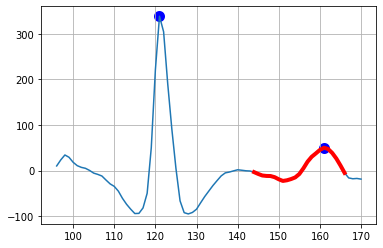

In [7]:
for index in ['30']:
    ecg = pd.read_csv(ecg_info_save_path+index+'_ecg_chan0.csv')
    heart_beat = pd.read_csv(ecg_info_save_path+index+'_heartbeat_chan0.csv')
    qwaves = pd.read_csv(ecg_info_save_path+index+'_qwaves_chan0.csv')
    rpeaks = np.array(pd.read_csv(ecg_info_save_path+index+'_rpeaks_chan0.csv')).flatten()
    twaves = pd.read_csv(ecg_info_save_path+index+'_twaves_chan0.csv')
    q_index = 0
    t_index = 0
    for i in range(1):
        plt.plot(ecg['ECG_Filtered'][rpeaks[i]-25:rpeaks[i]+50])
        plt.scatter(rpeaks[i],ecg['ECG_Filtered'][rpeaks[i]],c='b',linewidth=5)
        while rpeaks[i]-qwaves['q_onsets'].iloc[q_index]>75:
            q_index += 1
        while twaves['t_onsets'].iloc[t_index]-rpeaks[i]<0:
            t_index += 1
        if rpeaks[i]>qwaves['q_onsets'].iloc[q_index] and rpeaks[i]-qwaves['q_onsets'].iloc[q_index]<75:
            plt.scatter(qwaves['q_peaks'].iloc[q_index],ecg['ECG_Filtered'][qwaves['q_peaks'].iloc[q_index]],c='b',linewidth=5)
            plt.plot(ecg['ECG_Filtered'][qwaves['q_onsets'].iloc[q_index]:qwaves['q_peaks'].iloc[q_index]],linewidth=4,c='r')
        if twaves['t_onsets'].iloc[t_index]>rpeaks[i] and twaves['t_onsets'].iloc[t_index]-rpeaks[i]<75:
            plt.scatter(twaves['t_peaks'].iloc[t_index],ecg['ECG_Filtered'][twaves['t_peaks'].iloc[t_index]],c='b',linewidth=5)
            plt.plot(ecg['ECG_Filtered'][twaves['t_onsets'].iloc[t_index]:twaves['t_ends'].iloc[t_index]],linewidth=4,c='r')
        plt.grid('::')
        plt.show()

In [8]:
# 提取相关信息
# 修正质量较差的数据
# get_NSR_ecg_info(nsr_path,nsr_indexs,ecg_info_save_path,length=600,channels=[0,1],resample_fs=128)
# get_SCD_ecg_info(scd_path,scd_indexs,ecg_info_save_path,length=600,channels=[0,1],resample_fs=128)
# get_SCD_ecg_info(scd_path,['38','41','43'],ecg_info_save_path,length=600,channels=[0,1],resample_fs=128,polarity=-1)
# get_NSR_ecg_info(nsr_path,['18177','19090'],ecg_info_save_path,length=600,channels=[0,1],resample_fs=128)

In [33]:
def get_hrv_info(ecg_info_save_path, indexs, sampling_rate=1000, channels=[0,1]):
    for index in indexs:
        for c in channels:
            rpeaks = pd.read_csv(ecg_info_save_path+index+'_rpeaks_chan{}.csv'.format(c))
            hrv_info = ecg_hrv(np.asarray(rpeaks).flatten(),sampling_rate=sampling_rate)
            rr_intervals = hrv_info['RR_Intervals']
            hrv_freq_feature = hrv_info['df']
            del(hrv_info['RR_Intervals'])
            del(hrv_info['df'])
            hrv_info

    Using multitaper spectrum estimation with 7 DPSS windows
/root/anaconda3/envs/py36/lib/python3.6/site-packages/neurokit/signal/complexity.py:526: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)


In [52]:
a = ecg_hrv(np.asarray(rpeaks).flatten(),sampling_rate=250)


    Using multitaper spectrum estimation with 7 DPSS windows
/root/anaconda3/envs/py36/lib/python3.6/site-packages/neurokit/signal/complexity.py:526: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)
